# Act Log Analysis

In [2]:
# imports
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import scipy
from skimage import filters
from skimage import data
import seaborn as sns
from collections import Counter
import copy

In [3]:
# print and show what the entire dict looks like
def inspect_dict(d, level=0):
    """
    Recursively inspect a dictionary to determine its structure.
    
    Parameters:
    - d: Dictionary to inspect.
    - level: Current depth level (for nested dictionaries).
    """
    for key, value in d.items():
        indent = "  " * level  # Indentation for better readability
        if isinstance(value, dict):
            print(f"{indent}{key}: (Nested dictionary)")
            inspect_dict(value, level + 1)
        else:
            print(f"{indent}{key}: {type(value).__name__} (Value: {value})")

In [6]:
# Define the file paths
files = [
    '../../topk/base_auxt.pkl',
    '../../topk/base_hsm.pkl',
    '../../topk/base_hsm1.pkl',
    '../../topk/base_hsp.pkl',
    '../../topk/base_maths.pkl',
    '../../topk/base_physics.pkl',
]

# Load all files into a single dict
topk = {}

for file_path in files:
    with open(file_path, 'rb') as f:
        topk[file_path] = pickle.load(f)

In [5]:
hsm1 = topk['../../topk/base_hsm1.pkl']

# print first key in hsm1
print(hsm1.keys())
print(len(hsm1['model.layers.0.mlp.gate_proj']['indices']))

# get the number of all of the values stored in hsm1


dict_keys(['model.layers.0.mlp.gate_proj', 'model.layers.0.mlp.act_fn', 'model.layers.0.mlp.up_proj', 'model.layers.0.mlp.down_proj', 'model.layers.1.mlp.gate_proj', 'model.layers.1.mlp.act_fn', 'model.layers.1.mlp.up_proj', 'model.layers.1.mlp.down_proj', 'model.layers.2.mlp.gate_proj', 'model.layers.2.mlp.act_fn', 'model.layers.2.mlp.up_proj', 'model.layers.2.mlp.down_proj', 'model.layers.3.mlp.gate_proj', 'model.layers.3.mlp.act_fn', 'model.layers.3.mlp.up_proj', 'model.layers.3.mlp.down_proj', 'model.layers.4.mlp.gate_proj', 'model.layers.4.mlp.act_fn', 'model.layers.4.mlp.up_proj', 'model.layers.4.mlp.down_proj', 'model.layers.5.mlp.gate_proj', 'model.layers.5.mlp.act_fn', 'model.layers.5.mlp.up_proj', 'model.layers.5.mlp.down_proj', 'model.layers.6.mlp.gate_proj', 'model.layers.6.mlp.act_fn', 'model.layers.6.mlp.up_proj', 'model.layers.6.mlp.down_proj', 'model.layers.7.mlp.gate_proj', 'model.layers.7.mlp.act_fn', 'model.layers.7.mlp.up_proj', 'model.layers.7.mlp.down_proj', 'mode

In [4]:
# step 1: show hsm1 for topk of 3,100, and 1000
# show all the nodes activated per layer as a graph

# get the topk_act
def get_act_index(d,topk):
    act_index = []
    for layer_name, values in d.items():
        # removing down just because it has 4000 nodes per layer unlike the rest
        if "down" not in layer_name:
            for name, val in values.items():
                if name == "indices":
                    act_index.append(val[0:topk])
    return act_index

# print the graph for the items
# need to make a heat color based on the order of it
def show_act_in_layers(data,color):
    for row_index, row in enumerate(data):
        x_values = [row_index] * len(row)  # X-axis is the row index
        y_values = row  # Y-axis is the row values
        plt.scatter(
            x_values, 
            y_values, 
            marker='.', 
            s=20, 
            color=color,
            label=f"Row {row_index}"
        )

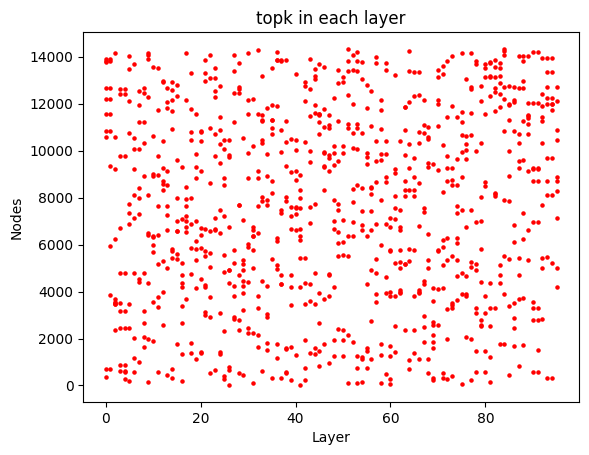

In [5]:
hsm1 = topk['../../topk/base_hsm1.pkl']

act_index1 = get_act_index(hsm1,10)
act_index10 = get_act_index(hsm1,50)
act_index25 = get_act_index(hsm1,200)

# show_act_in_layers(act_index25,"green")
# show_act_in_layers(act_index10,"blue")
show_act_in_layers(act_index1,"red")

# Add labels and title

plt.xlabel("Layer")
plt.ylabel("Nodes")
plt.title("topk in each layer")
plt.show()

realised the up proj max for topk is 4000 and therefore is a much more dense layer, but for the rest of them, they all go up to 14k. May want to either play with that or turn it off in the future

In [15]:
# showing it as a heat image where the order dictates the heat of it per layer

def topk_act_to_img(data, data_name):
    data = np.array(data)
    struct_data = np.zeros((len(data), np.max(data)+1))
    
    # change list struct
    for i, ival in enumerate(data):
        for j, jval in enumerate(ival):
            struct_data[i][jval] = len(ival) -  int(j)
    

    

    # generate the image
    plt.figure(dpi = 200)
    plt.imshow(struct_data.T, vmin=50, vmax=255, aspect = 0.006, cmap = "viridis")
    plt.xlabel("Layer")
    plt.ylabel("Node index")
    plt.title("Top-k in each layer for {}".format(data_name))
    plt.show()

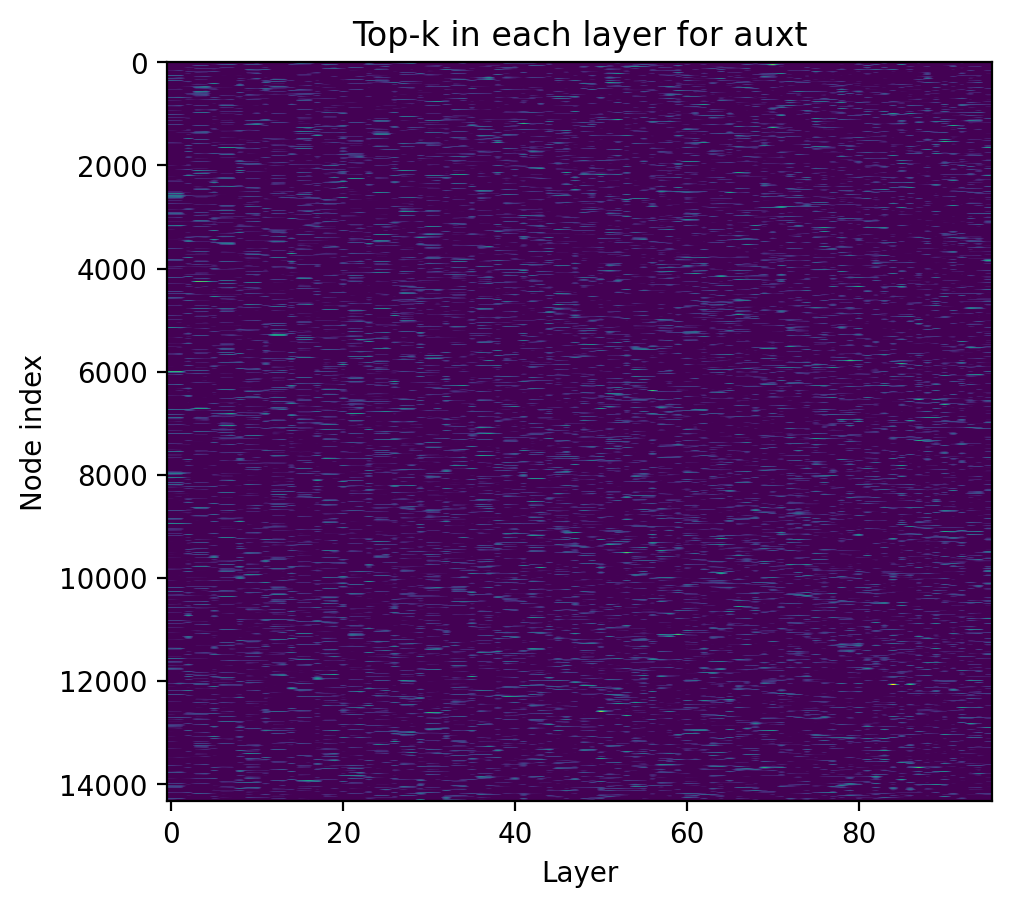

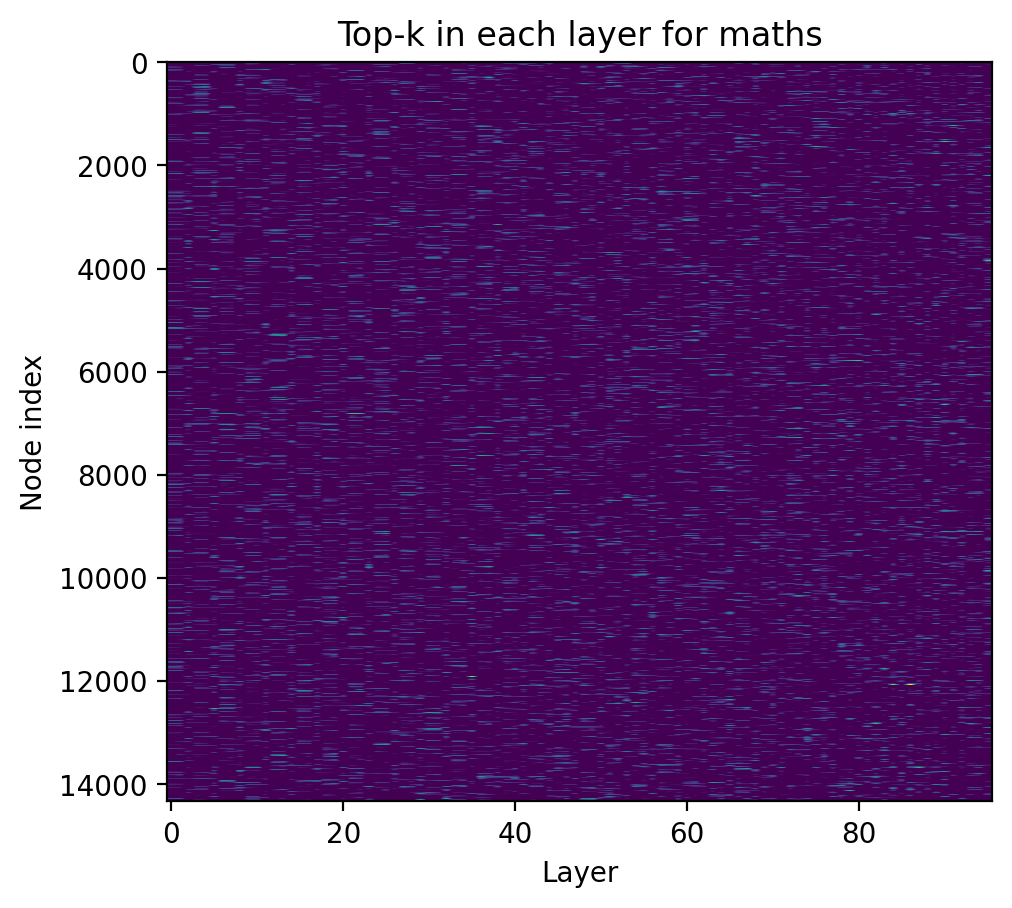

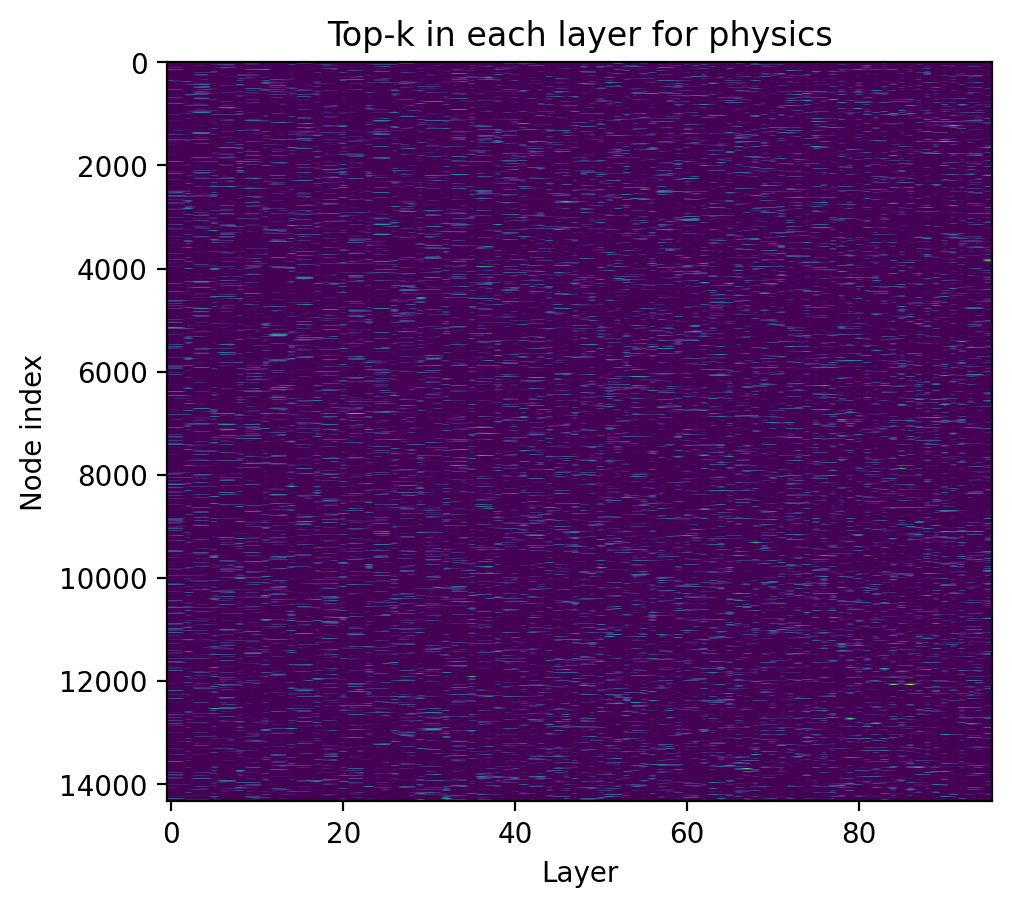

In [21]:
auxt = topk['../../topk/base_auxt.pkl']
act_index_auxt = get_act_index(auxt,1000)
topk_act_to_img(act_index_auxt,"auxt")

hsm = topk['../../topk/base_hsm.pkl']
act_index_hsm = get_act_index(hsm,1000)

hsp = topk['../../topk/base_hsp.pkl']
act_index_hsp = get_act_index(hsp,1000)

maths = topk['../../topk/base_maths.pkl']
act_index_maths = get_act_index(maths,1000)
topk_act_to_img(act_index_maths,"maths")

physics = topk['../../topk/base_physics.pkl']
act_index_physics = get_act_index(physics,1000)
topk_act_to_img(act_index_physics,"physics")


In [17]:
# step 2: show the difference between hsm and hsm1
# show the deviation amount in scores between the 2

# showing the percentage change
def compare_act_logs(d1,d2,topk:int):
    total_matched = 0
    total = 0

    for i in d1:
        for j in i:
            if j != None:
                total += 1 

    for i in range(len(d1)):
        for j in range(topk):
            if d2[i][j] != None:
                if d2[i][j] in d1[i]:    
                    total_matched += 1

    print ("total topk values: ", total)
    print ("total topk matched: ", total_matched)
    print ("percentage of topk matched: ", total_matched/total * 100,"%")

    return None


def subtract_act_logs(d1,d2):
    total = len(d1) * len(d1[0])
    print ("original total: ", total)

    d3 = copy.deepcopy(d1)
    
    total_subtracted = 0
    for i in range(len(d2)):
        for j in range(1000):
            if d1[i][j] in d2[i]:    
                d3[i][j] = None
                total_subtracted += 1

    print ("amount subtracted: ", total_subtracted)

    return d3

    



In [18]:
# step 3: show the topk of hsm and compare that to auxt and rand
# essentially showing that the activations are different to just random ones

# generate a random rand index
def gen_rand_act_index(data):
    row = len(data)
    col = len(data[0])

    max_val = max(map(max,data))

    print("max value: ",max_val)
    rand_data = np.random.randint(max_val,size = (row,col))

    return rand_data

# less entropy means that the data is less likely to be random (relative)
def rand_check(data, base_data):
    data = np.array(data)
    value_counts = np.bincount(data.flatten())
    entropy_value = scipy.stats.entropy(value_counts, base=2)
    
    base_data = np.array(base_data)
    base_value_counts = np.bincount(base_data.flatten())
    base_entropy_value = scipy.stats.entropy(base_value_counts, base=2)

    print(f"Entropy: {entropy_value}")
    print(f"Entropy relative to the base: {entropy_value/base_entropy_value}")

    return None

In [26]:
act_index_maths_sub_auxt = subtract_act_logs(act_index_maths, act_index_auxt)
act_index_physics_sub_auxt = subtract_act_logs(act_index_physics, act_index_auxt)

act_index_hsm_sub_auxt = subtract_act_logs(act_index_hsm, act_index_auxt)
act_index_hsp_sub_auxt = subtract_act_logs(act_index_hsp, act_index_auxt)

act_index_rand = gen_rand_act_index(act_index)

print("\n")
compare_act_logs(act_index_maths_sub_auxt,act_index_physics_sub_auxt,1000)
print("\n")
compare_act_logs(act_index_physics, act_index_maths, 1000)
print("\n")
compare_act_logs(act_index_maths, act_index_auxt, 1000)
print("\n")
compare_act_logs(act_index_physics, act_index_auxt, 1000)


# compare train with test
print("\n")
print("--- maths and hsm")
compare_act_logs(act_index_maths_sub_auxt, act_index_hsm_sub_auxt, 1000)
compare_act_logs(act_index_maths, act_index_hsm, 1000)
print("--- physics and hsp")
compare_act_logs(act_index_physics_sub_auxt, act_index_hsp_sub_auxt, 1000)
compare_act_logs(act_index_physics, act_index_hsp , 1000)
print("--- maths and hsp")
compare_act_logs(act_index_maths_sub_auxt, act_index_hsp_sub_auxt, 1000)
compare_act_logs(act_index_maths, act_index_hsp , 1000)
print("--- physics and hsm")
compare_act_logs(act_index_physics_sub_auxt, act_index_hsm_sub_auxt, 1000)
compare_act_logs(act_index_physics, act_index_hsm , 1000)




# random checks
print("\n")
print ("random ---------")
compare_act_logs(act_index_maths, act_index_rand, 1000)
print("\n")
compare_act_logs(act_index_physics, act_index_rand, 1000)
print("\n")
compare_act_logs(act_index_auxt, act_index_rand, 1000)

original total:  96000
amount subtracted:  53564
original total:  96000
amount subtracted:  54609
original total:  96000
amount subtracted:  52112
original total:  96000
amount subtracted:  60131
max value:  14335


total topk values:  42436
total topk matched:  26449
percentage of topk matched:  62.32679800169667 %


total topk values:  96000
total topk matched:  75523
percentage of topk matched:  78.66979166666667 %


total topk values:  96000
total topk matched:  53564
percentage of topk matched:  55.795833333333334 %


total topk values:  96000
total topk matched:  54609
percentage of topk matched:  56.884375 %


--- maths and hsm
total topk values:  42436
total topk matched:  11467
percentage of topk matched:  27.021868225091904 %
total topk values:  96000
total topk matched:  52075
percentage of topk matched:  54.24479166666667 %
--- physics and hsp
total topk values:  41391
total topk matched:  10695
percentage of topk matched:  25.838950496484742 %
total topk values:  96000
tot

In [27]:
rand_check(act_index_rand, act_index_auxt)
rand_check(act_index_physics, act_index_auxt)
rand_check(act_index_maths, act_index_auxt)

Entropy: 13.695720188931308
Entropy relative to the base: 1.004014376200444
Entropy: 13.642742718559562
Entropy relative to the base: 1.0001306708432804
Entropy: 13.641412647550569
Entropy relative to the base: 1.0000331651702692
